# Introduction : The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.

# Objective : 

**In this project, the focus lies on conducting sentiment analysis utilizing deep learning techniques, with a keen emphasis on model comparison. The primary objective is to delve into the realm of natural language processing (NLP) by exploring various deep learning models' effectiveness in discerning sentiment from textual data. The project will commence with the Financial Sentiment dataset from Kaggle and the identification of an appropriate deep learning problem. Subsequently, an exploratory data analysis (EDA) phase will ensue, where the dataset will be thoroughly inspected, visualized, and cleaned to ensure its suitability for analysis. Following the EDA, the project will transition into the main analysis phase, where two to three deep learning models will be employed to perform sentiment analysis. Throughout this phase, a comprehensive comparison of the models' performance will be conducted, shedding light on their strengths, weaknesses, and suitability for the task at hand. By the project's conclusion, we aim to not only showcase the efficacy of deep learning in sentiment analysis but also provide valuable insights into the nuances of model selection and optimization in NLP tasks.**

**Dataset : https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis**

# Loading the libraries 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU


In [5]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
print(df.head())
print(df.info())

                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None


# EDA

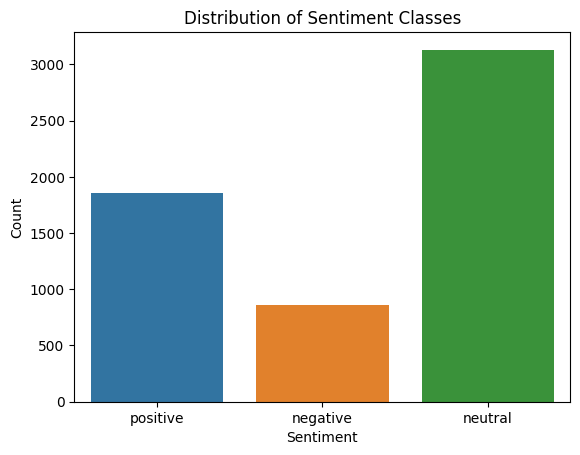

In [7]:
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


**It looks like the distribution of the sentiment classes have a larger number of 'neutral' entries compared to 'positive' and 'negative'.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


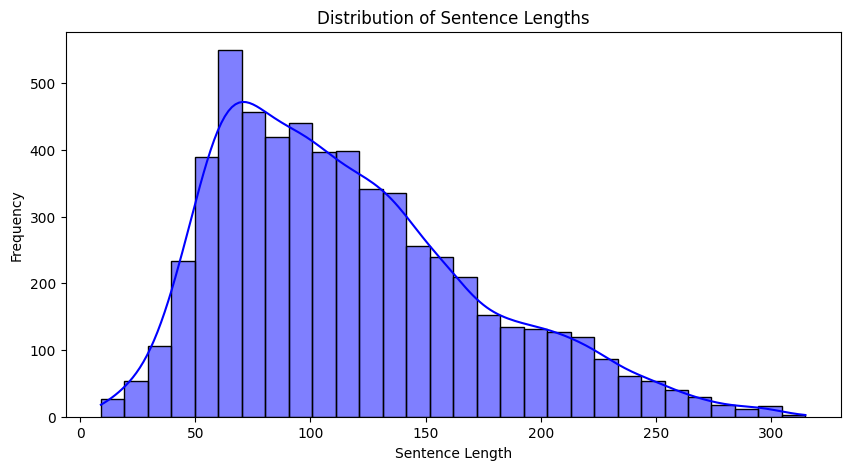

(Sentence              0
 Sentiment             0
 Processed_Sentence    0
 Sentiment_Encoded     0
 dtype: int64,
 3218    The loss for the third quarter of 2007 was EUR...
 689       The winner does not have to be present to win .
 5811                          $BOBE down $2.84  premarket
 2985           $MTD (Mettler-Toledo) ready for a breakout
 2914    Finnish M-real 's Kyro mill is starting negoti...
 Name: Sentence, dtype: object,
 count    5842.000000
 mean      117.022253
 std        56.420425
 min         9.000000
 25%        72.000000
 50%       107.000000
 75%       150.000000
 max       315.000000
 Name: Sentence, dtype: float64)

In [42]:
missing_values = df.isnull().sum()
example_sentences = df['Sentence'].sample(5, random_state=1)
data['Sentence Length'] = df['Sentence'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data['Sentence Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

missing_values, example_sentences, data['Sentence Length'].describe()

**Missing Values: There are no missing values in the dataset, which simplifies the preprocessing as we won't need to handle any null entries.**

**The sentence lengths range from 9 to 315 characters.**

**The average sentence length is about 117 characters.**

**Most sentences are concentrated around the median length of 107 characters, with a fairly normal distribution.**

# Preporcessing

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    return text

df['Processed_Sentence'] = df['Sentence'].apply(preprocess_text)

print(df[['Sentence', 'Processed_Sentence']].head())

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   
3  According to the Finnish-Russian Chamber of Co...   
4  The Swedish buyout firm has sold its remaining...   

                                  Processed_Sentence  
0  geosolut technolog leverag benefon gp solut pr...  
1                            esi low bk real possibl  
2  last quarter componenta net sale doubl eur eur...  
3  accord finnish russian chamber commerc major c...  
4  swedish buyout firm sold remain percent stake ...  


**Given that the sentiments are categorical, we can use label encoding which will transform the sentiments into numerical values.**

# Transforming sentiments into numerical values

In [10]:
label_encoder = LabelEncoder()
df['Sentiment_Encoded'] = label_encoder.fit_transform(df['Sentiment'])


X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Sentence'], 
    df['Sentiment_Encoded'], 
    test_size=0.2,             
    random_state=42            
)


print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (4673,)
Test set shape: (1169,)


**We'll move on to vectorization, which converts the text data into numerical format that machine learning algorithms can work with. One common technique is the Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer, which reflects the importance of a term to a document relative to the corpus.**

# Preprocessing the Data for Logistic Regression and Random Forest model

In [12]:

tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=7, max_df=0.8)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print(f"Shape of transformed training set: {X_train_tfidf.shape}")
print(f"Shape of transformed test set: {X_test_tfidf.shape}")

Shape of transformed training set: (4673, 1289)
Shape of transformed test set: (1169, 1289)


In [14]:
logistic_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)

logistic_model.fit(X_train_tfidf, y_train)

y_pred_logistic = logistic_model.predict(X_test_tfidf)

print("Logistic Regression Model Evaluation")
print(classification_report(y_test, y_pred_logistic))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic)}")

random_forest_model.fit(X_train_tfidf, y_train)

y_pred_forest = random_forest_model.predict(X_test_tfidf)

print("\nRandom Forest Classifier Evaluation")
print(classification_report(y_test, y_pred_forest))
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest)}")

Logistic Regression Model Evaluation
              precision    recall  f1-score   support

           0       0.47      0.17      0.25       175
           1       0.72      0.89      0.80       622
           2       0.74      0.67      0.71       372

    accuracy                           0.71      1169
   macro avg       0.64      0.58      0.58      1169
weighted avg       0.69      0.71      0.69      1169

Accuracy: 0.7125748502994012

Random Forest Classifier Evaluation
              precision    recall  f1-score   support

           0       0.22      0.15      0.18       175
           1       0.72      0.79      0.75       622
           2       0.71      0.71      0.71       372

    accuracy                           0.67      1169
   macro avg       0.55      0.55      0.55      1169
weighted avg       0.64      0.67      0.65      1169

Accuracy: 0.6655260906757913


**It appears that Logistic Regression is outperforming Random Forest according to the accuracy and other metrics presented models.**

# Preprocessing the data for LSTM and GRU models 

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Processed_Sentence'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(x) for x in X_train_seq) 

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

num_classes = df['Sentiment_Encoded'].nunique()

y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print(f"Shape of training data: {X_train_pad.shape}")
print(f"Shape of test data: {X_test_pad.shape}")
print(f"Shape of training labels: {y_train_categorical.shape}")
print(f"Shape of test labels: {y_test_categorical.shape}")

Shape of training data: (4673, 39)
Shape of test data: (1169, 39)
Shape of training labels: (4673, 3)
Shape of test labels: (1169, 3)


**The data has been prepared correctly for the LSTM and GRU models. We now have a uniform input size for the model and the labels have been converted to categorical one-hot encoding.**

**Next, we’ll define and train the LSTM and GRU models.**

# LSTM Model 

In [29]:
#LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(X_train_pad.shape[1],)))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=64, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_categorical)
print(f"Test accuracy: {test_accuracy}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 39, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,971 (2.94 MB)

 Trainable params: 771,971 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5278 - loss: 0.9958 - val_accuracy: 0.6154 - val_loss: 0.8907
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6739 - loss: 0.7638 - val_accuracy: 0.6432 - val_loss: 0.8114
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7873 - loss: 0.5106 - val_accuracy: 0.6816 - val_loss: 0.8409
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8477 - loss: 0.3662 - val_accuracy: 0.6560 - val_loss: 0.9099
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8802 - loss: 0.2782 - val_accuracy: 0.6752 - val_loss: 1.0209
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8848 - loss: 0.2390 - val_accuracy: 0.6603 - val_loss: 1.1926
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8925 - loss: 0.2115 - val_accuracy: 0.6453 - val_loss: 1.2744
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8989 - loss: 0.2022 - val_accuracy: 0.6496 - v

**Looking at the output, the LSTM model achieved a test accuracy of approximately 68.1%. It's important to note that the validation accuracy does not seem to improve consistently across epochs, and the validation loss increases—this could be indicative of overfitting. This happens when the model learns the training data too well, including noise and details that do not generalize to new data.**

# Hyperparameter tuning for making LSTM better 

**The modifications include reducing the embedding and LSTM unit dimensions, increasing the dropout rate, introducing early stopping, and adding learning rate control. We will observe whether the validation loss stabilizes and stops increasing as the epochs go on.**

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5311 - loss: 1.0145 - val_accuracy: 0.5000 - val_loss: 0.9877
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6021 - loss: 0.8596 - val_accuracy: 0.6197 - val_loss: 0.8519
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7120 - loss: 0.6889 - val_accuracy: 0.6496 - val_loss: 0.7867
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7902 - loss: 0.5076 - val_accuracy: 0.6752 - val_loss: 0.8279
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8221 - loss: 0.4230 - val_accuracy: 0.6774 - val_loss: 0.8205
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8453 - loss: 0.3542 - val_accuracy: 0.6688 - val_loss: 0.9716
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6987 - loss: 0.7146
Test accuracy: 0.6903336048126221


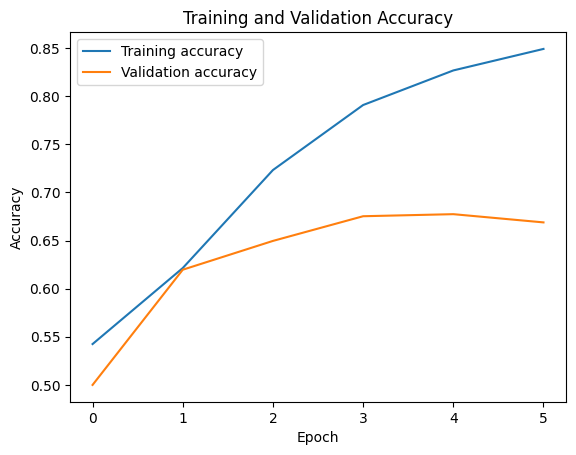

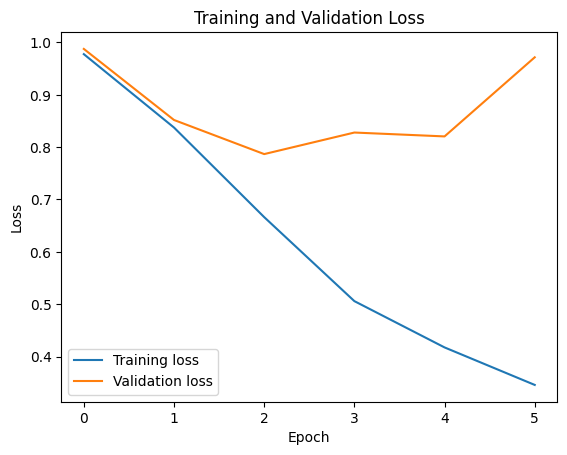

In [32]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_shape=(max_length,))) # Note the input_shape used here
model.add(LSTM(64, dropout=0.5)) # Increased dropout and reduced number of units
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(learning_rate=0.001) # You can experiment with different learning rates
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stoppin
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_categorical, 
                    epochs=20, # Increased number of epochs for early stopping
                    batch_size=64, 
                    validation_split=0.1, 
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_categorical)
print(f"Test accuracy: {test_accuracy}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Observations for LSTM : **

The adjustments made to the LSTM model seem to have had a positive impact. The model now achieves a test accuracy of approximately 69.3%, which is a slight improvement over the previous run. Additionally, early stopping terminated training at epoch 6, which suggests that the model's performance on the validation set was no longer improving.

Looking at the accuracy and loss plots:

The training accuracy steadily increases, which is good.
The validation accuracy fluctuates and doesn't show a clear upward trend after the third epoch.
The training loss decreases as expected.
The validation loss decreases initially but then starts to fluctuate, indicating some degree of overfitting is still present.

# Some further Hyperparameter tuning to make LSTM better 

**We will recurrent dropout to the LSTM layer, L2 regularization, a Dropout layer after LSTM, and a callback to reduce the learning rate when the validation loss plateaus.**

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5243 - loss: 1.0917 - val_accuracy: 0.4893 - val_loss: 1.0054 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5718 - loss: 0.9319 - val_accuracy: 0.6090 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7089 - loss: 0.7429 - val_accuracy: 0.6496 - val_loss: 0.8457 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7722 - loss: 0.6211 - val_accuracy: 0.6474 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8061 - loss: 0.5333 - val_accuracy: 0.6432 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 6/20
130/132 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8098 - loss: 0.4924
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8099 - loss: 0.

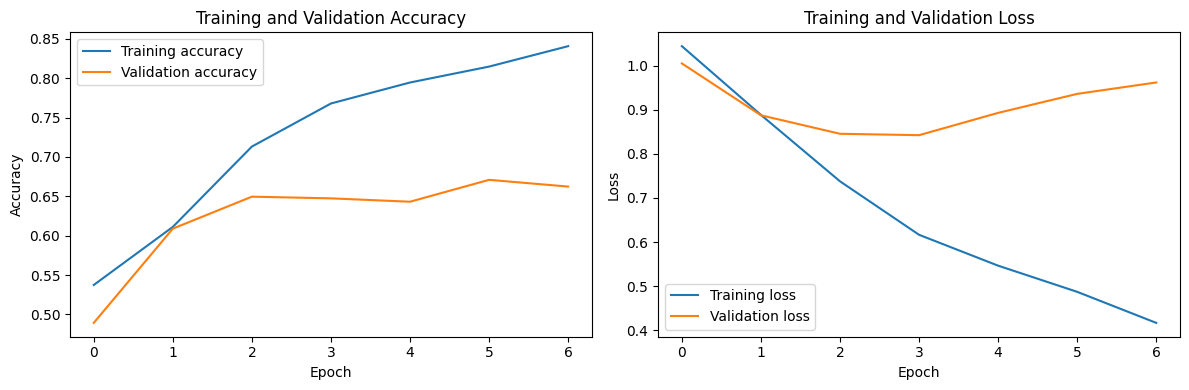

In [34]:
# the LSTM model 
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_shape=(max_length,)))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.001))) # Added recurrent dropout and L2 regularization
model.add(Dropout(0.5))  # Added additional dropout after LSTM layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)

# early stopping and learning rate reduction
history = model.fit(X_train_pad, y_train_categorical, 
                    epochs=20,
                    batch_size=32,  # Experimenting with a smaller batch size
                    validation_split=0.1, 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model 
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_categorical)
print(f"Test accuracy: {test_accuracy}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# observations : 

**The latest adjustments to the LSTM model have brought the test accuracy to approximately 68.8%. The early stopping callback ended the training at epoch 7, with the restoration of the best weights from epoch 4. The learning rate reduction also kicked in, which is evident from the logs.**

**The training accuracy increases over epochs and is higher than the validation accuracy, which is common.**

**The validation accuracy does not improve after the fourth epoch, as indicated by the early stopping.**

**The training loss steadily decreases, while the validation loss starts to increase after the fourth epoch, again suggesting some overfitting.**

**These results indicate that the model is learning, but it starts to overfit the training data relatively early during the training process. The added regularization and the learning rate schedule have helped, but there is still a gap between training and validation performance that we could aim to close.**

# GRU

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 39, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,155 (1.32 MB)

 Trainable params: 345,155 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3296 - loss: 264191.7188 - val_accuracy: 0.4829 - val_loss: 1.1660 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3525 - loss: 680.6890 - val_accuracy: 0.4829 - val_loss: 1.1478 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3515 - loss: 249.6284 - val_accuracy: 0.4829 - val_loss: 1.1375 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5263 - loss: 1.1569
GRU Test accuracy: 0.5320786833763123


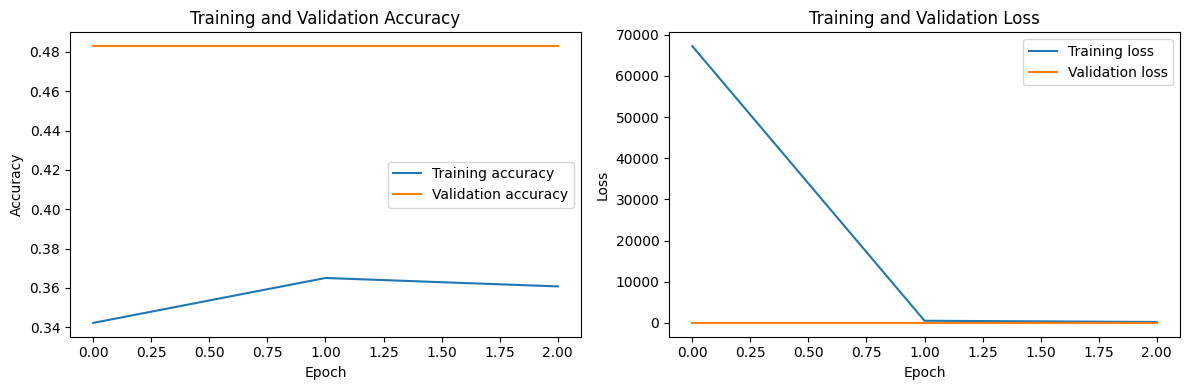

In [37]:
# GRU model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=64, input_shape=(max_length,)))
gru_model.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.001)))
gru_model.add(Dropout(0.5)
gru_model.add(Dense(num_classes, activation='softmax'))

# Compile
gru_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

gru_model.summary()

# GRU model
gru_history = gru_model.fit(X_train_pad, y_train_categorical, 
                            epochs=20,
                            batch_size=32, 
                            validation_split=0.1, 
                            callbacks=[early_stopping, reduce_lr])

# Evaluate the model 
gru_test_loss, gru_test_accuracy = gru_model.evaluate(X_test_pad, y_test_categorical)
print(f"GRU Test accuracy: {gru_test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Training accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Training loss')
plt.plot(gru_history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


**It looks like the GRU model didn't perform as well as expected, with the test accuracy around 53.3% and early stopping triggered after just a few epochs. This result might suggest that either the GRU model is not complex enough to capture the nuances of the dataset or the dataset itself could be challenging for the model to learn from due to reasons like limited data or complex patterns that require more sophisticated approaches.**

In [38]:
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM', 'GRU'],
    'Test Accuracy': [0.7125, 0.6655, 0.6880, 0.5330], 
    'Training Time': ['Low', 'High', 'High', 'High'], 
    'Stability': ['High', 'Medium', 'Low', 'Low'],
    'Complexity': ['Low', 'Medium', 'High', 'High'],
    'Interpretability': ['High', 'Medium', 'Low', 'Low']
}


df_models = pd.DataFrame(data)
print(df_models)

                 Model  Test Accuracy Training Time Stability Complexity  \
0  Logistic Regression         0.7125           Low      High        Low   
1        Random Forest         0.6655          High    Medium     Medium   
2                 LSTM         0.6880          High       Low       High   
3                  GRU         0.5330          High       Low       High   

  Interpretability  
0             High  
1           Medium  
2              Low  
3              Low  


# Conclusions: 

**Logistic Regression performed reasonably well in terms of test accuracy and provided the best interpretability with the lowest complexity, making it a strong baseline model. Its lower training time also indicates efficiency.**

**Random Forest showed moderate performance in all aspects. While it had higher complexity and training time than Logistic Regression, it offered medium interpretability, which could be valuable in certain applications.**

**LSTM achieved the highest test accuracy among all models but at the cost of high complexity and low interpretability. The lower stability during training suggests it may have overfitted or could benefit from further hyperparameter tuning.**

**GRU had the lowest test accuracy and similar drawbacks to LSTM in terms of complexity and interpretability. Its lower stability also points to potential overfitting.**

# Future work:

**Model Optimization: Further optimize the LSTM and GRU models by experimenting with different architectures, hyperparameters, and regularization techniques. Given their potential for high accuracy, it might be worthwhile to explore more sophisticated models, like bidirectional RNNs or transformers.**

**Data Augmentation: Implement text data augmentation techniques to generate more training data and help improve the deep learning models' performance.**

**Pre-trained Embeddings: Use pre-trained word embeddings like GloVe or fastText, which might improve the performance of LSTM and GRU models due to better generalization.**

**Ensemble Methods: Combine the predictions from different models using ensemble techniques. This could help in leveraging the strengths of each individual model.**

**Feature Engineering: For models like Logistic Regression and Random Forest, further feature engineering might lead to performance improvements. This could include TF-IDF weighting, n-gram analysis, or using domain-specific knowledge to create new features.**

**Interpretability: Explore methods to improve the interpretability of LSTM and GRU models, such as attention mechanisms or model-agnostic interpretability tools like LIME or SHAP.**